In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

## Classification

### Logistic regression summary

The logistic or sigmoid function can be written two equivalent ways:

$$\sigma(t) = \frac{1}{1 + \exp(-t)} = \frac{\exp(t)}{1 + \exp(t)} $$

The logistic regression model assumes the following probabilities of $Y \in \{0, 1\}$ given column vector $X$:

\begin{align*}
P(Y=1|X) &= \sigma(X^T \beta) &&= \frac{1}{1 + \exp(-X^T \beta)} &= \frac{\exp(X^T\beta)}{1 + \exp(X^T\beta)} \\[10pt]
P(Y=0|X) &= \sigma(-X^T \beta) &&= \frac{1}{1 + \exp(X^T \beta)}  \\
\end{align*}

The loss most typically used to fit $\beta$ is the log loss or cross-entropy loss, which is the negative log probability of the correct (observed) $Y$ value. This loss for true $Y \in \{0, 1\}$ and predicted probability $\hat Y \in [0, 1]$ is often written:

$$-Y \log(\hat Y) - (1-Y)\log(1- \hat Y)$$

In [2]:
def sigma(t):
    """The logistic or sigmoid function, denoted σ(t).
    
    Note: This is actually a special case of what is generally 
          named the "logistic" function,
          which allows for a different numerator and offset, 
          but lots of people call this the logistic function in practice.
    """
    return 1 / (1 + np.exp(-t))

def prediction(x, beta):
    """Prediction under the logistic model for features x and parameters b."""
    return sigma(x @ beta)

def squared_loss(y, y_hat):
    """Squared loss applies to any true y and predicted y_hat."""
    return (y - y_hat) ** 2

def log_loss(y, y_hat):
    """Log loss or cross-entropy loss, assuming y is in [0, 1]."""
    assert y in [0, 1]
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

def empirical_risk(true_ys, predicted_ys, loss):
    """The empirical risk is the average loss for a sample."""
    losses = [loss(y, y_hat) for y, y_hat in zip(true_ys, predicted_ys)]
    return np.average(losses)

### Empirical Risk

Filling in $\hat Y = P(Y=1|X)$ and filling in the form of the model, we find different ways of expressing the same loss:

\begin{align*}
L(\beta) &= -Y \log(\hat Y) - (1-Y)\log(1- \hat Y) \\[10pt]
         &= - Y \log P(Y=1|X) - (1-Y) \log P(Y=0|X)  \\[10pt]
         &= - Y \log \frac{\exp(X^T\beta)}{1 + \exp(X^T\beta)} - (1-Y) \log \frac{1}{1 + \exp(X^T\beta)}  \\[10pt]
         &= - Y (\log(\exp(X^T\beta)) - \log(1 + \exp(X^T\beta))) - (1-Y) (-\log (1 + \exp(X^T\beta)))  \\[10pt]
         &= - YX^T\beta + Y \log(1 + \exp(X^T\beta))) - Y \log(1 + \exp(X^T\beta))) + \log (1 + \exp(X^T\beta))  \\[10pt]
         &= - YX^T\beta + \log (1 + \exp(X^T\beta)) \\[10pt]
         &= -\left(YX^T\beta + \log \sigma(-X^T\beta)\right)
\end{align*}

Where the last step follows from $\log (1 + \exp(X^T\beta)) = -(- \log (1 + \exp(X^T\beta))) = -\log \frac{1}{1 + \exp(X^T\beta)} = -\log \sigma(-X^T\beta)$.

The empirical risk (average loss across a sample) for a set of observations $(x_1, y_1) \dots (x_n, y_n)$ is often written:

$$R(\beta, x, y) = - \frac{1}{n} \sum_{i=1}^n \left[ y_i x_i^T\beta + \log \sigma(-x_i^T\beta) \right]$$

### Logistic Regression Gradient

Using thelogistic regression model and log loss, find the gradient of the empirical risk.

First, we compute the derivative of the sigmoid function since we'll use it in our gradient calculation.

$$
\begin{aligned}
\sigma(t) &= \frac{1}{1 + e^{-t}} \\[10pt]
\sigma'(t) &= \frac{e^{-t}}{(1 + e^{-t})^2} \\[10pt]
\sigma'(t) &= \frac{1}{1 + e^{-t}} \cdot \left(1 - \frac{1}{1 + e^{-t}} \right) \\[10pt]
\sigma'(t) &= \sigma(t) (1 - \sigma(t))
\end{aligned}
$$

As a shorthand, we define $ \sigma_i = \sigma(-x_i^T \beta) $. We will soon need the gradient of $ \sigma_i $ with respect to the vector $ \beta $ so we will derive it now using the chain rule. 

\begin{align*}
\nabla_{\beta} \sigma_i
&= \nabla_{\beta} \sigma(-x_i^T \beta) \\[10pt]
&= \sigma\left(-x_i^T \beta\right) \left(1 - \sigma(-x_i^T \beta)\right)  \nabla_{\beta} \left(-x_i^T \beta\right) \\[10pt]
&= -\sigma_i (1 - \sigma_i) x_i 
\end{align*}

Now, we derive the gradient of the cross-entropy loss with respect to the model parameters $ \boldsymbol{\beta} $. We use the fact that $(1-\sigma_i) = \sigma(x_i^T\beta)$, since $\sigma(x^T\beta) + \sigma(-x^T\beta) = 1$.

\begin{align*}
R(\beta, x, y) &= - \frac{1}{n}\sum_{i=1}^n \left[ y_i x_i^T\beta + \log \sigma_i \right] \\[10pt]
\nabla_{\beta} R(\beta, x, y) &= - \frac{1}{n}\sum_{i=1}^n \left( y_i x_i - \frac{1}{\sigma_i} \sigma_i (1 - \sigma_i) x_i \right) \\[10pt]
                              &= - \frac{1}{n}\sum_{i=1}^n \left( y_i x_i - \sigma(x_i^T\beta) x_i \right) \\[10pt]
                              &= - \frac{1}{n}\sum_{i=1}^n \left(y_i - \sigma(x_i^T\beta)\right) x_i  \\[10pt]
\end{align*}

In [3]:
def gradient_descent(x, y, beta0, gradient_function, max_iter=50000,  
                     epsilon=1e-8, lr=0.1, clip=1):
    """Run gradient descent on a dataset (x, y) 
    with gradient clipping and learning rate decay."""
    beta = beta0
    for t in range(1, max_iter):
        grad = gradient_function(beta, x, y)
        beta = beta - (lr/(1 + t/100)) * np.clip(grad, -clip, clip) 
        # Detect approximate convergence: small gradient
        if np.linalg.norm(grad) < epsilon:
            return beta
    return beta

def risk_gradient(beta, x, y):
    """Risk gradient for a whole dataset at once."""
    n = x.shape[0]
    return -(1/n) * x @ (y - sigma(x.T @ beta)) 

def logistic_regression(x, y):
    """Train a logistic regression classifier using gradient descent."""
    beta0 = np.zeros(x.shape[0])
    beta = gradient_descent(x, y, beta0, risk_gradient)
    return beta    

### Applying logistic regression

In [4]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
cancer = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
cancer['bias'] = 1.0
# Target data_dict['target'] = 0 is malignant; 1 is benign
cancer['malignant'] = 1 - data_dict['target']
cancer.iloc[0]

mean radius                  17.990000
mean texture                 10.380000
mean perimeter              122.800000
mean area                  1001.000000
mean smoothness               0.118400
mean compactness              0.277600
mean concavity                0.300100
mean concave points           0.147100
mean symmetry                 0.241900
mean fractal dimension        0.078710
radius error                  1.095000
texture error                 0.905300
perimeter error               8.589000
area error                  153.400000
smoothness error              0.006399
compactness error             0.049040
concavity error               0.053730
concave points error          0.015870
symmetry error                0.030030
fractal dimension error       0.006193
worst radius                 25.380000
worst texture                17.330000
worst perimeter             184.600000
worst area                 2019.000000
worst smoothness              0.162200
worst compactness        

In [5]:
cancer.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,bias,malignant
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.0,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,1.0,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.0,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,1.0,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,1.0,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.0,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.0,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.0,1.000000


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cancer, test_size=0.25, random_state=100)
print("Training Data Size: ", len(train))
print("Test Data Size: ", len(test))

Training Data Size:  426
Test Data Size:  143


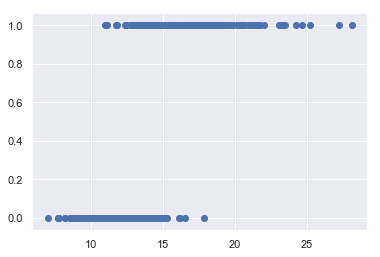

In [7]:
plt.scatter(train['mean radius'], train['malignant']);

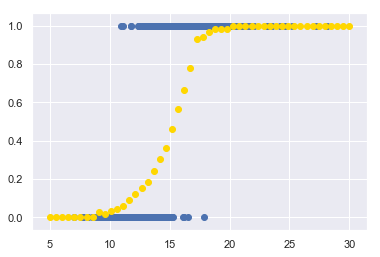

In [24]:
radii = np.linspace(5, 30, 50)
averages = [np.average(train[np.abs(train['mean radius']-r)<2]['malignant']) for r in radii]
plt.scatter(train['mean radius'], train['malignant']);
plt.scatter(radii, averages, color='gold');

In [9]:
def features(t):
    return t[['bias', 'mean radius']].values.T
    
x_train, y_train = features(train), train['malignant'].values

In [10]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=False, C=1e9, solver='lbfgs')
model.fit(x_train.T, y_train)
model.coef_

array([[-14.8970826 ,   1.01064211]])

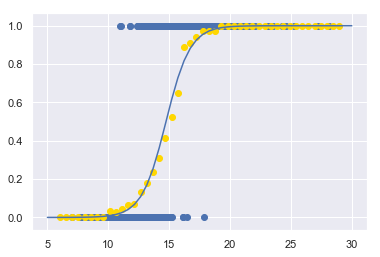

In [11]:
plt.scatter(train['mean radius'], train['malignant']);
plt.scatter(radii, averages, color='gold');
plt.plot(radii, sigma(model.coef_[0,0] + radii * model.coef_[0,1]));

In [12]:
beta = logistic_regression(x_train, y_train)
beta

array([-14.86831235,   1.00862628])

In [13]:
risk_gradient(beta, x_train, y_train)

array([ 0.00645167, -0.00045204])

In [14]:
def print_ratio(n, d):
    print('{}/{} ({:.1f}%)'.format(n, d, 100 * n/d))

def accuracy(x, y, beta):
    y_hat = np.round(sigma(x.T @ beta))
    guesses = np.round(y_hat)
    correct = y == guesses
    print_ratio(sum(correct), len(guesses))

accuracy(x_train, y_train, beta)

370/426 (86.9%)


In [15]:
x_test = features(test)
y_test = test['malignant'].values
print_ratio(sum(1-y_test), len(y_test))

87/143 (60.8%)


In [16]:
accuracy(x_test, y_test, beta)

130/143 (90.9%)


In [17]:
def all_features(t):
    return t.drop('malignant', axis=1).values.T

def evaluate(beta, features):
    print('Train:', end=' ')
    accuracy(features(train), y_train, beta)
    print('Test:', end=' ')
    accuracy(features(test), y_test, beta)
    
beta = logistic_regression(all_features(train), y_train)
evaluate(beta, all_features)

Train: 406/426 (95.3%)
Test: 137/143 (95.8%)


### Regularized Logistic Regression

As with linear regression, one common way of reducing the variance of the parameter estimator is to add a regularization term to the empirical risk objective. E.g.,

\begin{align*}
R(\beta, x, y, \lambda) &= - \frac{1}{n}\sum_{i=1}^n \left[ y_i x_i^T\beta + \log \sigma(-x_i^T\beta) \right] + \frac{1}{2} C \sum_{j=1}^J \beta_j^2 \\[10pt]
\nabla_{\beta} R(\beta, x, y, \lambda) &=  - \frac{1}{n}\sum_{i=1}^n \left(y_i - \sigma(x_i^T\beta)\right) x_i + C \beta \\[10pt]
\end{align*}

In [18]:
def regularized_logistic_regression(x, y, c):
    """Train a logistic regression classifier using gradient descent."""

    def l2_regularized_gradient(beta, x, y):
        return risk_gradient(beta, x, y) + c * beta

    beta0 = np.zeros(x.shape[0])
    beta = gradient_descent(x, y, beta0, l2_regularized_gradient)
    return beta    

def search_for_c(features):
    for c in 2.0 ** np.arange(-10, 10, 2):
        print("c =", c)
        beta = regularized_logistic_regression(features(train), y_train, c)
        print("sum(beta**2) = ", sum(beta**2))
        evaluate(beta, features)
        print()
        
search_for_c(all_features)

c = 0.0009765625
sum(beta**2) =  181.05862166469308
Train: 406/426 (95.3%)
Test: 137/143 (95.8%)

c = 0.00390625
sum(beta**2) =  153.17656348299207
Train: 406/426 (95.3%)
Test: 137/143 (95.8%)

c = 0.015625
sum(beta**2) =  84.76727676186307
Train: 401/426 (94.1%)
Test: 139/143 (97.2%)

c = 0.0625
sum(beta**2) =  16.86808437919907
Train: 396/426 (93.0%)
Test: 137/143 (95.8%)

c = 0.25
sum(beta**2) =  1.159763781457247
Train: 392/426 (92.0%)
Test: 135/143 (94.4%)

c = 1.0
sum(beta**2) =  0.21983095016705734
Train: 390/426 (91.5%)
Test: 134/143 (93.7%)

c = 4.0
sum(beta**2) =  0.08526863018405177
Train: 390/426 (91.5%)
Test: 134/143 (93.7%)

c = 16.0
sum(beta**2) =  0.06240644243334323
Train: 390/426 (91.5%)
Test: 134/143 (93.7%)

c = 64.0
sum(beta**2) =  0.043885815938907356
Train: 388/426 (91.1%)
Test: 134/143 (93.7%)

c = 256.0
sum(beta**2) =  0.016109390288629684
Train: 387/426 (90.8%)
Test: 136/143 (95.1%)



In [19]:
from sklearn import preprocessing

def inputs(t):
    return t.drop('malignant', axis=1).values

scaler = preprocessing.StandardScaler().fit(inputs(train))

def scaled_features(t):
    return scaler.transform(inputs(t)).T

search_for_c(scaled_features)

c = 0.0009765625
sum(beta**2) =  35.8486017048037
Train: 423/426 (99.3%)
Test: 138/143 (96.5%)

c = 0.00390625
sum(beta**2) =  31.318273815172542
Train: 423/426 (99.3%)
Test: 138/143 (96.5%)

c = 0.015625
sum(beta**2) =  20.747956964144077
Train: 423/426 (99.3%)
Test: 139/143 (97.2%)

c = 0.0625
sum(beta**2) =  9.935156093274612
Train: 421/426 (98.8%)
Test: 141/143 (98.6%)

c = 0.25
sum(beta**2) =  4.279626098449614
Train: 419/426 (98.4%)
Test: 141/143 (98.6%)

c = 1.0
sum(beta**2) =  1.717220435886093
Train: 414/426 (97.2%)
Test: 140/143 (97.9%)

c = 4.0
sum(beta**2) =  0.6094833404635616
Train: 412/426 (96.7%)
Test: 139/143 (97.2%)

c = 16.0
sum(beta**2) =  0.17553643009069883
Train: 405/426 (95.1%)
Test: 138/143 (96.5%)

c = 64.0
sum(beta**2) =  0.03500234439319296
Train: 403/426 (94.6%)
Test: 136/143 (95.1%)

c = 256.0
sum(beta**2) =  0.0041317425176505785
Train: 399/426 (93.7%)
Test: 134/143 (93.7%)



In [20]:
model = LogisticRegression(C=4, solver='lbfgs')
model.fit(scaled_features(train).T, y_train)
y_hat = model.predict(scaled_features(test).T)
print_ratio(sum(y_hat == y_test), len(y_test))

138/143 (96.5%)


### Multiclass classification

\begin{align*}
P(Y=y|X) &= \frac{\exp(X^T\beta_{y})}{\sum_{z=0}^d \exp(X^T\beta_z)} \\[10pt]
L(\beta_0,\dots,\beta_d, x_i, y_i) &= - \log \frac{\exp(x_i^T\beta_{y_i})}{\sum_{z=0}^d \exp(x_i^T\beta_z)} \\[10pt]
\frac{\partial}{\partial \beta_w} L(\beta_0,\dots,\beta_d, x_i, y_i) &= -\left(1[w=y_i] - \frac{\exp(x_i^T\beta_w)}{\sum_{z=0}^d \exp(x_i^T\beta_z)}\right) x_i  \\[10pt]
1[w=y_i] &= \begin{cases}
1 & \text{if}\ w=y_i \\
0 & \text{otherwise}
\end{cases}
\end{align*}


In [21]:
data_dict = sklearn.datasets.load_iris()
x = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
y = data_dict['target']
x.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [22]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([50, 50, 50]))